<a href="https://colab.research.google.com/github/Hyunjin-Austin/predict-HCV/blob/main/Predict_High_Risk_Donors_for_Hepatitis_C(Final).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Predict High-Risk Donors for Hepatitis C

### 1. Load Packages and data

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [5]:
data = pd.read_csv('/content/drive/MyDrive/Predict HCV/hcvdat0.csv', index_col=0)
display(data.shape)
data.head()

(615, 13)

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
1,0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
2,0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
3,0=Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
4,0=Blood Donor,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
5,0=Blood Donor,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


<font color = 'blue'>

* Goal of this project is to predict if suspect blood donors (0s=suspect Blood Donor) have Hepatitis C. </font>

In [6]:
# Check data type and any NA values
df = data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 615 entries, 1 to 615
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Category  615 non-null    object 
 1   Age       615 non-null    int64  
 2   Sex       615 non-null    object 
 3   ALB       614 non-null    float64
 4   ALP       597 non-null    float64
 5   ALT       614 non-null    float64
 6   AST       615 non-null    float64
 7   BIL       615 non-null    float64
 8   CHE       615 non-null    float64
 9   CHOL      605 non-null    float64
 10  CREA      615 non-null    float64
 11  GGT       615 non-null    float64
 12  PROT      614 non-null    float64
dtypes: float64(10), int64(1), object(2)
memory usage: 67.3+ KB


* <font color = 'blue'> Found NA values in 'ALB', 'ALP', 'ALT', 'CHOL', and 'PROT' columns.

### 2. Preprocess the data

<font color = 'blue'>

* Fill NA values with the mean of each category using 'SimpleImputer' </font>

In [7]:
print(f'Total Number of NA values: {df.isna().sum().sum()}')
print(df.isna().sum())

Total Number of NA values: 31
Category     0
Age          0
Sex          0
ALB          1
ALP         18
ALT          1
AST          0
BIL          0
CHE          0
CHOL        10
CREA         0
GGT          0
PROT         1
dtype: int64


In [8]:
from sklearn.impute import SimpleImputer

In [9]:
# Group mean imputer
def group_mean_imputer(df, group_col, target_col):
  imputed_df = df.copy()

  for group in imputed_df[group_col].unique():
    group_data = imputed_df[imputed_df[group_col] == group]
    imputer = SimpleImputer(strategy = 'mean')
    imputed_values = imputer.fit_transform(group_data[[target_col]])

    imputed_df.loc[imputed_df[group_col] == group, target_col] = imputed_values

  return imputed_df

In [10]:
target_col_list = df.drop(columns = ['Sex', 'Category'], axis = 1).columns.to_list()

In [11]:
# Preprocess the NA values by 'Category' group mean
for unique_group in target_col_list :
  df = group_mean_imputer(df, 'Category', unique_group)

In [12]:
# Replaces all NA values with group mean
print(f'NA values after processing : {df.isna().sum()}')

NA values after processing : Category    0
Age         0
Sex         0
ALB         0
ALP         0
ALT         0
AST         0
BIL         0
CHE         0
CHOL        0
CREA        0
GGT         0
PROT        0
dtype: int64


In [13]:
print(df['Category'].value_counts())

Category
0=Blood Donor             533
3=Cirrhosis                30
1=Hepatitis                24
2=Fibrosis                 21
0s=suspect Blood Donor      7
Name: count, dtype: int64


<font color = 'blue'>

* Due to class imbalnce, chose to merge all Hepatitis C patients data into one one category 'patient' (feature engineering)
  * 0: Blood donor
  * 1: Hepatitis C virus
* Exclude 'suspect blood donor' data from modeling for final test
</font>

In [14]:
# Convert 'Category' column into integer type
df['Category'] = df['Category'].map({'0=Blood Donor':0, '3=Cirrhosis' : 3, '1=Hepatitis' : 1, '2=Fibrosis' : 2, '0s=suspect Blood Donor' : 4})
df['Category'].value_counts()

,count
Category,
0,533
3,30
1,24
2,21
4,7


In [15]:
df2 = df.copy()

# Exclude 'suspect donor' data
df2 = df2[df2['Category'] != 4]

print(f'Dimension of Original Data: {df.shape}')
print(f'Dimension of Excluding suspect donors: {df2.shape}')

# merge advanced stage into one category
df2['patient'] = 0
df2.loc[df2['Category'] != 0, 'patient'] = 1

Dimension of Original Data: (615, 13)
Dimension of Excluding suspect donors: (608, 13)


In [16]:
df2['patient'].value_counts(normalize = True)

,proportion
patient,
0,0.876645
1,0.123355


### 3. Visualize the data

In [17]:
df2.head()

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,patient
1,0,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0,0
2,0,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5,0
3,0,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3,0
4,0,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7,0
5,0,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7,0


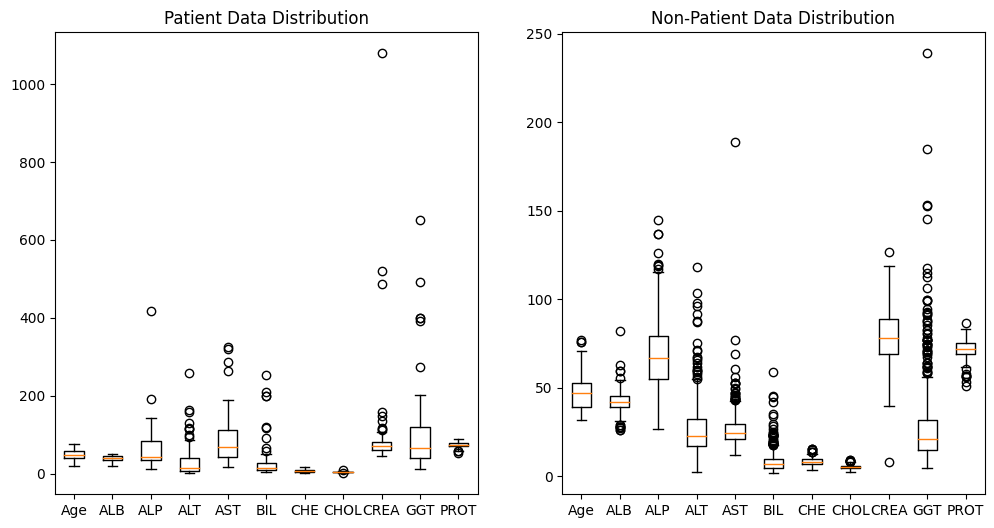

In [18]:
patient_data = df2[df2['patient'] == 1]
non_patient_data = df2[df2['patient'] == 0]

labels_patient = patient_data.drop(columns=['patient', 'Sex', 'Category'], axis = 1).columns.to_list()
labels_non_patient = non_patient_data.drop(columns=['patient', 'Sex', 'Category'], axis = 1).columns.to_list()

# Plot the data distribution
fig, axes = plt.subplots(1,2, figsize = (12, 6))
axes[0].boxplot(patient_data.drop(columns = ['patient', 'Sex', 'Category'], axis = 1), labels = labels_patient)
axes[0].set_title('Patient Data Distribution')

axes[1].boxplot(non_patient_data.drop(columns = ['patient', 'Sex', 'Category'], axis = 1), labels = labels_non_patient)
axes[1].set_title('Non-Patient Data Distribution')

plt.show()

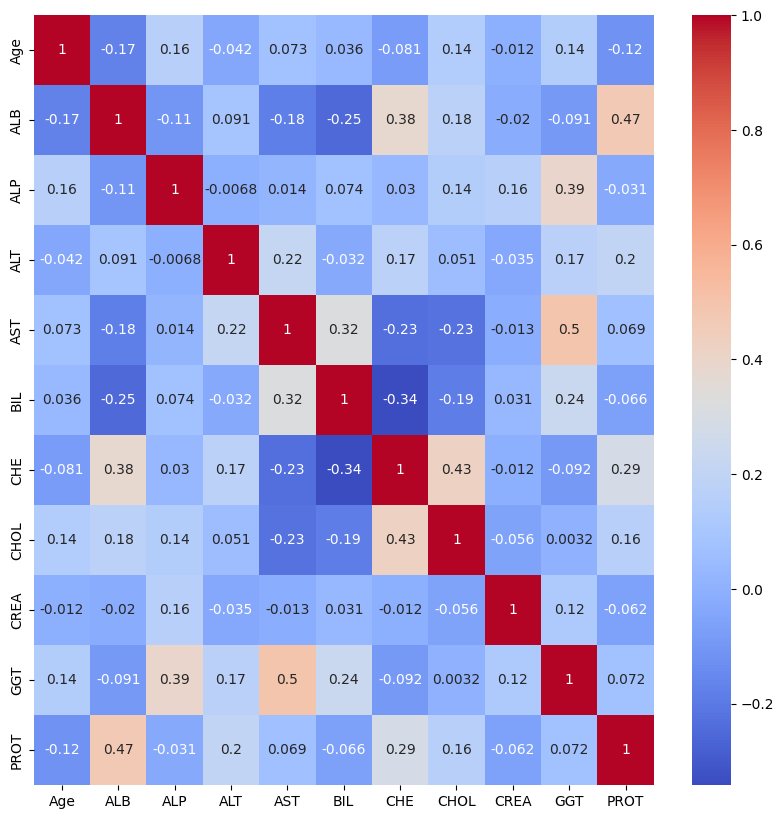

In [19]:
test_items = df2.drop(columns=['Category', 'Sex'], axis = 1)

fig, ax = plt.subplots(figsize = (10,10))
ax = sns.heatmap(test_items.iloc[:,:-1].corr(), annot = True, cmap = 'coolwarm')
plt.show()

<font color = 'blue'>

* Identified there are several correlation between variables.
  * PROT - ALB
  * GGT - AST
  * CHE - CHOL
* To prevent dimensionality reduction and overfitting, use random forest model to find important features
</font>

### Find Feature Importances through Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from imblearn.over_sampling import SMOTE

In [21]:
df2.head()

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,patient
1,0,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0,0
2,0,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5,0
3,0,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3,0
4,0,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7,0
5,0,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7,0


In [22]:
modeling_df = df2.copy()
X = modeling_df.drop(columns = ['Category', 'Sex', 'patient'], axis = 1)
y = modeling_df['patient']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, stratify=y, random_state = 42)

In [24]:
# SMOTE the train data
smote = SMOTE(random_state = 42)
X_train_smoted, y_train_smoted = smote.fit_resample(X_train, y_train)

# Scale the data
scaler = StandardScaler()
X_train_smoted_scaled = scaler.fit_transform(X_train_smoted)
X_test_scaled = scaler.transform(X_test)

# Train the model
rf_model = RandomForestClassifier(n_estimators = 500, random_state = 42)

In [25]:
rf_model.fit(X_train_smoted_scaled, y_train_smoted)

RandomForestClassifier(n_estimators=500, random_state=42)

In [26]:
y_pred = rf_model.predict(X_test_scaled)

In [27]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
print(f'Random Forest Model F1 score: {f1_score(y_test, y_pred)}')
print(f'Random Forest Model Precision score: {precision_score(y_test, y_pred)}')
print(f'Random Forest Model Accuracy score: {accuracy_score(y_test, y_pred)}')
print(f'Random Forest Model Recall score: {recall_score(y_test, y_pred)}')
print(f'Random Forest Model ROC score: {roc_auc_score(y_test, y_pred)}')

Random Forest Model F1 score: 0.9655172413793104
Random Forest Model Precision score: 1.0
Random Forest Model Accuracy score: 0.9918032786885246
Random Forest Model Recall score: 0.9333333333333333
Random Forest Model ROC score: 0.9666666666666667


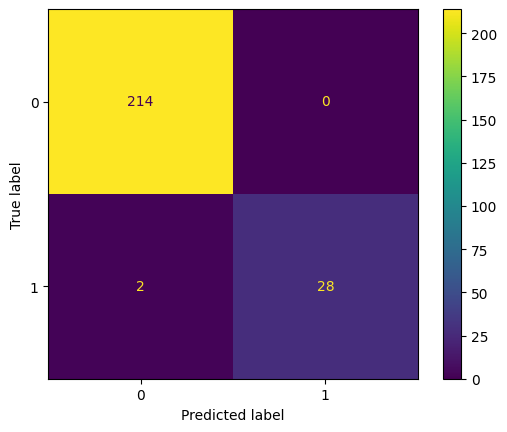

In [28]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = rf_model.classes_)
disp.plot()
plt.show()

In [29]:
feature_importances = rf_model.feature_importances_
importance_df = pd.DataFrame({'Feature' : X_train_smoted.columns, 'Importance' : feature_importances}).sort_values('Importance', ascending = False).reset_index(drop = True)

importance_df.head(5)

,Feature,Importance
0,AST,0.390782
1,GGT,0.154913
2,BIL,0.131706
3,ALP,0.122773
4,ALT,0.057114


<font color = 'blue'>

* Through simple random forest classifier, identified 5 high importance features (AST, GGT, BIL, ALP, and ALT) with F1 score of 0.96.
* Able to assume that these features are important to predict Hepatitis C patients.
* Added additional features, ALB and CHOL, considering current testing items.
</font>

### Build K-NN Model

In [30]:
from sklearn.neighbors import KNeighborsClassifier

In [31]:
# Extract the dataset
model_features = ['AST', 'GGT', 'BIL', 'ALP', 'ALT', 'ALB', 'CHOL', 'patient']

important_df_patient = df2[model_features].loc[df2['patient'] == 1]
important_df_non_patient = df2[model_features].loc[df2['patient'] == 0]

print(important_df_patient.shape)
print(important_df_non_patient.shape)

(75, 8)
(533, 8)


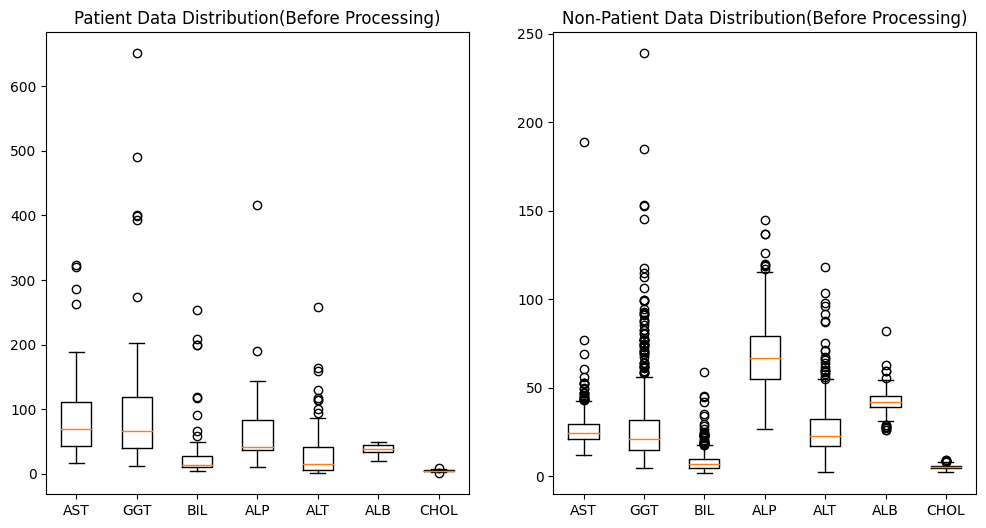

In [32]:
important_df_labels = important_df_patient.drop(columns = ['patient'], axis = 1).columns.to_list()

# Plot important features distribution
fig, axes = plt.subplots(1,2, figsize = (12, 6))
axes[0].boxplot(important_df_patient.drop(columns = ['patient'], axis = 1),labels = important_df_labels)
axes[0].set_title('Patient Data Distribution(Before Processing)')
axes[1].boxplot(important_df_non_patient.drop(columns = ['patient'], axis = 1), labels = important_df_labels)
axes[1].set_title('Non-Patient Data Distribution(Before Processing)')
plt.show()

In [33]:
# Get list of feature variance descending order
columns_to_remove_outliers = important_df_non_patient.var().sort_values(ascending = False).index.to_list()[:-1]
columns_to_remove_outliers

['GGT', 'ALP', 'ALT', 'AST', 'BIL', 'ALB', 'CHOL']

In [42]:
# Remove outliers using Z score
from scipy import stats

def remove_outliers(df, columns) :
  threshold = 3

  for col in columns :
    col_z_score = np.abs(stats.zscore(df[col]))
    df = df[(col_z_score < threshold)]

  return df

In [43]:
important_df_patient_no_outliers = remove_outliers(important_df_patient, columns_to_remove_outliers)
important_df_non_patient_no_outliers = remove_outliers(important_df_non_patient, columns_to_remove_outliers)
print(important_df_patient_no_outliers.shape)
print(important_df_non_patient_no_outliers.shape)

(64, 8)
(494, 8)


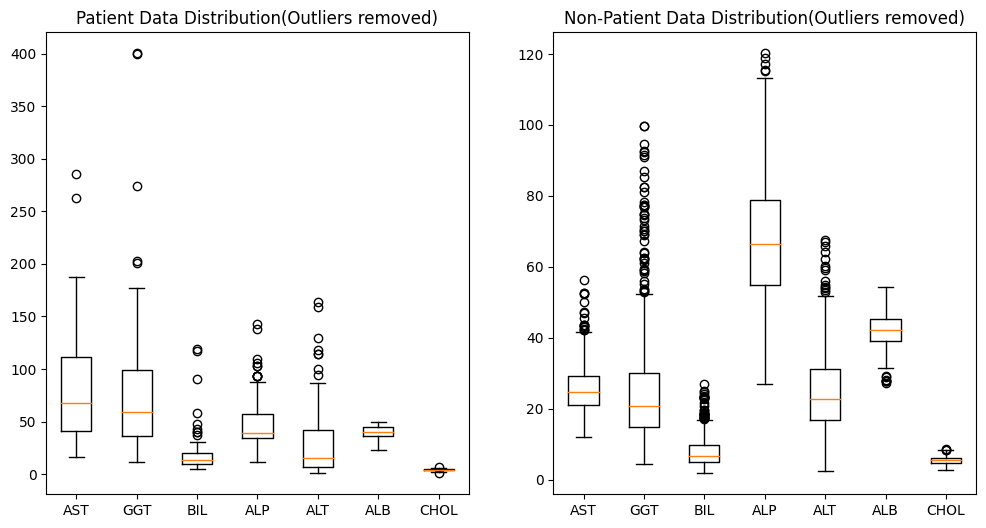

In [44]:
# Plot distribution after removing outliers
fig, axes = plt.subplots(1,2, figsize = (12,6))
axes[0].boxplot(important_df_patient_no_outliers.drop(columns = ['patient'], axis = 1), labels = important_df_labels)
axes[0].set_title('Patient Data Distribution(Outliers removed)')

axes[1].boxplot(important_df_non_patient_no_outliers.drop(columns = ['patient'], axis = 1), labels = important_df_labels)
axes[1].set_title('Non-Patient Data Distribution(Outliers removed)')
plt.show()

In [45]:
knn_model_df = pd.concat([important_df_patient_no_outliers, important_df_non_patient_no_outliers])
knn_model_df.head()

,AST,GGT,BIL,ALP,ALT,ALB,CHOL,patient
541,33.1,18.9,7.0,56.300000,26.9,45.0,6.00,1
542,67.0,65.0,12.0,42.114286,87.0,41.0,3.90,1
543,164.2,90.4,17.0,19.100000,38.9,47.0,3.20,1
544,187.7,40.2,14.0,38.200000,63.3,42.0,4.28,1
545,37.8,35.9,10.0,27.500000,10.5,45.0,3.20,1


In [46]:
print(knn_model_df['patient'].value_counts())
print(knn_model_df['patient'].value_counts(normalize = True))

patient
0    494
1     64
Name: count, dtype: int64
patient
0    0.885305
1    0.114695
Name: proportion, dtype: float64


<font color = 'blue'>

* Undersampled non-patient data (patient 0), considering the class imbalance. </font>

In [48]:
# Undersample Patient 0
sample_0 = knn_model_df[knn_model_df['patient'] == 0].sample(n = 250)
knn_model_df_undersampled = pd.concat([sample_0, knn_model_df[knn_model_df['patient'] != 0]])
knn_model_df_undersampled['patient'].value_counts(normalize = True)

,proportion
patient,
0,0.796178
1,0.203822


In [49]:
display(knn_model_df_undersampled.shape)
knn_model_df_undersampled.head()

(314, 8)

,AST,GGT,BIL,ALP,ALT,ALB,CHOL,patient
333,17.0,7.0,7.3,82.2,11.9,38.5,3.92,0
284,26.6,51.4,15.2,60.5,35.4,34.3,7.62,0
1,22.1,12.1,7.5,52.5,7.7,38.5,3.23,0
325,52.3,44.7,8.5,74.0,49.7,44.3,3.34,0
502,26.7,11.3,6.5,80.9,33.1,38.6,5.10,0


In [50]:
X = knn_model_df_undersampled.drop(columns = 'patient', axis = 1)
y = knn_model_df_undersampled['patient']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, stratify=y, random_state = 42)

In [52]:
# Set KFold
kfold = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)

# SMOTE data
smote = SMOTE(random_state = 42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Scale the data
scaler = StandardScaler()
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

print(X_train_smote.shape)
print(y_train_smote.shape)
print(X_test_scaled.shape)
print(y_test.shape)

(300, 7)
(300,)
(126, 7)
(126,)


In [53]:
# Find the optimal k
k_range = range(1,31)
f1_scores = []

for k in k_range:
  knn_model = KNeighborsClassifier(n_neighbors = k, weights='distance')
  cv_scores = cross_val_score(knn_model, X_train_smote_scaled, y_train_smote, cv = kfold, scoring = 'f1', n_jobs = -1)
  f1_scores.append(cv_scores.mean())

knn_df = pd.DataFrame({'K': k_range, 'F1 Score': f1_scores})

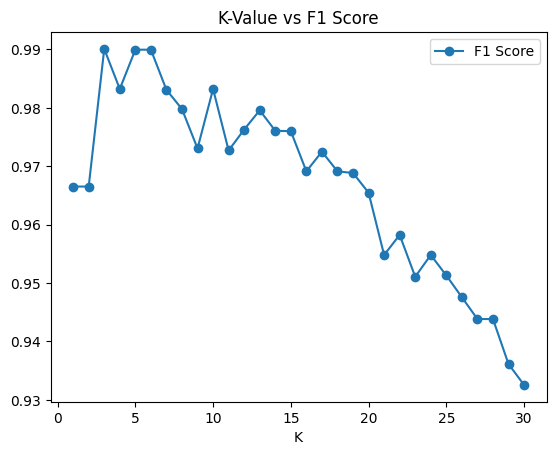

In [54]:
knn_df.plot.line(x = 'K', y = 'F1 Score', style = '-o')
plt.title('K-Value vs F1 Score')
plt.show()

In [55]:
knn_df[knn_df['K']%2 != 0].sort_values('F1 Score', ascending = False).head()

,K,F1 Score
2,3,0.990097
4,5,0.989966
6,7,0.983094
12,13,0.979588
14,15,0.976008


<font color = 'blue'>

* Identified K values 3 showed highest F1 scores. The F1 score declines after 7 which means the model performance is degraded as complexity of data decreases.
* After cross validating, 3 could be an optimal K value for this dataset.</font>

In [56]:
%%time
# Fit to the final model using optimal k
optimal_k = 3

optimal_knn_model = KNeighborsClassifier(n_neighbors = optimal_k, weights='distance')
optimal_knn_model.fit(X_train_smote_scaled, y_train_smote)

CPU times: user 3.93 ms, sys: 0 ns, total: 3.93 ms
Wall time: 6.37 ms


KNeighborsClassifier(n_neighbors=3, weights='distance')

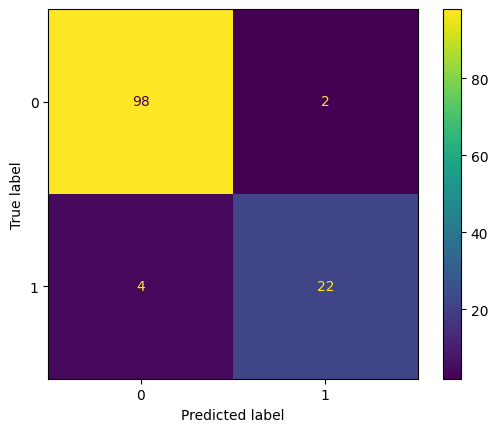

In [57]:
# Measure model performance
y_pred = optimal_knn_model.predict(X_test_scaled)

# Display Confusion Matrix
knn_cm = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred), display_labels = optimal_knn_model.classes_)
knn_cm.plot()
plt.show()

In [58]:
optimal_k_F1_score = f1_score(y_test, y_pred)
optimal_k_precision_score = precision_score(y_test, y_pred)
optimal_k_recall_score = recall_score(y_test, y_pred)
optimal_k_roc_score = roc_auc_score(y_test, y_pred)

test_result = pd.DataFrame({'Model' : 'KNN Model (K_5)',
                                      'F1 Score' : [optimal_k_F1_score],
                                      'Precision' : [optimal_k_precision_score],
                                      'Recall' : [optimal_k_recall_score],
                                      'ROC' : [optimal_k_roc_score]})

test_result

,Model,F1 Score,Precision,Recall,ROC
0,KNN Model (K_5),0.88,0.916667,0.846154,0.913077


<font color = 'blue'>

* KNN model with optimal k of 3 showed high performace with F1 score of 0.88, precision score of 0.91, recall score of 0.84, and ROC score of 0.91. </font>

In [ ]:
print("Shape of X_train_smote_scaled:", X_train_smote_scaled.shape)
print("Shape of X_test_scaled:", X_test_scaled.shape)

Shape of X_train_smote_scaled: (638, 11)
Shape of X_test_scaled: (244, 11)


#### Compare Model Performance with Logistic Regression

In [59]:
# Compare model performance with LogisticRegression
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter = 1000)
lr_model.fit(X_train_smote_scaled, y_train_smote)

lr_y_pred = lr_model.predict(X_test_scaled)

lr_F1_score = f1_score(y_test, lr_y_pred)
lr_precision_score = precision_score(y_test, lr_y_pred)
lr_recall_score = recall_score(y_test, lr_y_pred)
lr_roc_score = roc_auc_score(y_test, lr_y_pred)

lr_test_result = pd.DataFrame({'Model' : 'Logistic Regression',
                                      'F1 Score' : [lr_F1_score],
                                      'Precision' : [lr_precision_score],
                                      'Recall' : [lr_recall_score],
                                      'ROC' : [lr_roc_score]})

test_result = pd.concat([test_result, lr_test_result])

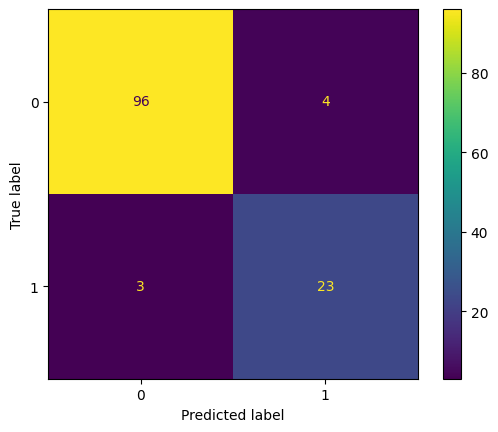

In [67]:
cm = confusion_matrix(y_test, lr_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = lr_model.classes_)
disp.plot()
plt.show()

In [60]:
test_result

,Model,F1 Score,Precision,Recall,ROC
0,KNN Model (K_5),0.880000,0.916667,0.846154,0.913077
0,Logistic Regression,0.867925,0.851852,0.884615,0.922308


### Test Best K-NN Model

* Using the best KNN model, predict 'suspected blood donors' stage.

In [64]:
suspect_df = df[df['Category'] == 4]

display(suspect_df.shape)
suspect_df

(7, 13)

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
534,4,47,m,22.5,124.0,79.5,46.7,2.3,6.83,4.30,170.0,345.6,58.6
535,4,48,m,24.9,116.9,49.2,24.3,4.9,3.44,5.25,29.0,83.0,47.8
536,4,49,m,21.6,42.2,9.5,10.6,2.4,3.75,3.01,64.0,38.9,44.8
537,4,55,m,47.3,106.0,208.8,130.6,0.8,14.80,8.08,76.0,71.6,78.3
538,4,71,m,14.9,69.8,19.7,95.2,9.8,13.30,2.61,9.0,7.6,47.0
539,4,74,m,20.3,84.0,22.8,43.0,5.7,4.91,3.19,52.0,218.3,47.8
540,4,59,f,19.3,208.2,325.3,146.6,6.9,5.33,4.72,32.0,295.6,53.1


In [65]:
new_df = suspect_df[['AST', 'GGT', 'BIL', 'ALP', 'ALT', 'ALB', 'CHOL']]

new_df_scaled = scaler.transform(new_df)

In [66]:
prediction = optimal_knn_model.predict(new_df_scaled)
print(f'Predicted class for the suspect blood donors : {prediction}')

Predicted class for the suspect blood donors : [1 1 1 1 1 1 1]


<font color = 'blue'>

* The model predicted all suspected donors are high risk donors for Hepatitis C.
* Blood center can futher investigate these donors' blood sample to prevent any tranmission of Hepatitis C to recipient.